In [2]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import shap


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [4]:
df = pd.read_excel("loan_dataset_investor.xlsx")
df.head()

,loan_id,country,loan_issued_at,early_repaid_at,is_early_repaid_within_14_days,issued_amount,loan_status,loan_last_recorded_action_date_local,initial_interest_rate,nr_of_payments,...,days_past_due_principal,months_in_default,months_on_book,loan_status_risk,repaid_amount_total,initial_loan_duration,combined_income,has_default_within_12_months,projected_npv_return,customer_risk_rating
0,260FB2E2-8612-4763-B7B1-B36300920BD5,Finland,2025-09-25 08:56:06.550,NaN,NaN,200.0,Active,NaN,0.1748,78,...,NaN,NaN,0.0,Active,2.32,78,1842.36,NaN,0.016153,D
1,40B2AA74-E887-4E7C-A320-B20F013F62A2,Finland,2024-10-20 19:27:50.397,NaN,NaN,4249.0,Active,NaN,0.1877,15,...,NaN,NaN,12.0,Active,2444.13,60,1045.76,NaN,0.108182,C
2,4A8CB94A-5E70-4919-A0C1-B22D00DEE6E7,Finland,2024-11-19 13:33:31.477,NaN,NaN,207.0,Active,NaN,0.1877,49,...,NaN,NaN,11.0,Active,91.15,12,2189.57,NaN,0.147670,A
3,5247E7B9-67A1-40C4-A080-AAD600C37593,Spain,2019-09-28 11:54:11.000,NaN,NaN,4253.0,Repaid,2025-07-21 00:00:00,0.2620,51,...,1505.0,NaN,24.0,Written Off,4399.03,36,NaN,0.0,NaN,NaN
4,566F0EC7-1334-4C9B-9F4E-AC1B00BF8FD6,Estonia,2020-08-18 11:45:09.000,NaN,NaN,1063.0,Repaid,2025-08-20 00:00:00,0.3586,60,...,NaN,NaN,60.0,Paid Up,2503.64,60,NaN,0.0,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644037 entries, 0 to 644036
Data columns (total 31 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   loan_id                               644037 non-null  object        
 1   country                               644037 non-null  object        
 2   loan_issued_at                        644037 non-null  datetime64[ns]
 3   early_repaid_at                       177106 non-null  object        
 4   is_early_repaid_within_14_days        177106 non-null  float64       
 5   issued_amount                         644037 non-null  float64       
 6   loan_status                           644037 non-null  object        
 7   loan_last_recorded_action_date_local  261815 non-null  object        
 8   initial_interest_rate                 644037 non-null  float64       
 9   nr_of_payments                        644037 non-null  int6

In [5]:
df.describe()

,loan_issued_at,is_early_repaid_within_14_days,issued_amount,initial_interest_rate,nr_of_payments,principal_balance,principal_debt,principal_paid_total,interest_paid_total,extra_interest_paid_total,...,is_default,next_payment_nr,days_past_due_principal,months_in_default,months_on_book,repaid_amount_total,initial_loan_duration,combined_income,has_default_within_12_months,projected_npv_return
count,644037,177106.000000,644037.000000,644037.000000,644037.000000,636324.000000,636324.000000,636324.000000,636324.000000,636324.000000,...,636324.000000,636324.000000,191252.000000,115332.000000,635851.000000,636324.000000,644037.000000,370883.000000,475199.000000,371754.000000
mean,2022-07-15 02:01:57.050968320,0.158391,2264.764752,0.222996,51.596283,1118.407772,382.579212,1069.753570,489.320367,1.274490,...,0.181247,3.534548,962.428796,36.295616,15.195702,1642.462012,53.632762,2543.799355,0.161189,0.103826
min,2009-02-28 18:05:13,0.000000,6.390000,0.010000,1.000000,-34.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-334.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.286456
25%,2020-10-13 11:35:10,0.000000,531.000000,0.174800,9.000000,0.000000,0.000000,97.760000,34.480000,0.000000,...,0.000000,0.000000,204.000000,11.000000,4.000000,218.420000,36.000000,1669.420000,0.000000,0.071110
50%,2023-06-26 10:14:02.492999936,0.000000,1554.000000,0.187700,48.000000,290.610000,0.000000,479.440000,164.210000,0.000000,...,0.000000,0.000000,706.000000,28.000000,10.000000,742.205000,60.000000,2322.190000,0.000000,0.101910
75%,2024-11-04 22:15:12.089999872,0.000000,3721.000000,0.230800,84.000000,1649.400000,0.000000,1309.907500,566.892500,0.000000,...,0.000000,4.000000,1559.000000,60.000000,20.000000,2215.022500,60.000000,3033.460000,0.000000,0.135248
max,2025-09-30 02:12:13.450000,1.000000,20000.000000,2.643100,180.000000,20000.000000,15000.000000,19989.000000,28934.820000,5755.770000,...,1.000000,60.000000,5866.000000,190.000000,152.000000,37946.840000,120.000000,177871.700000,1.000000,0.350112
std,NaN,0.365108,2202.358569,0.145096,43.130837,1797.572217,1101.286345,1568.460186,915.964658,29.419091,...,0.385223,6.952660,907.689423,30.369172,15.848199,2240.282156,23.513078,1637.827796,0.367706,0.050781


In [6]:
missing_data = df.isnull().sum()
missing_percent = missing_data * 100 / len(df)
missing_summary = pd.DataFrame({'Missing_Count': missing_data,'Missing_Percent': missing_percent})

missing_summary_display = missing_summary.copy()
missing_summary_display['Missing_Percent'] = missing_summary_display['Missing_Percent'].apply(lambda x: f"{x:.2f}%")
print(missing_summary_display)

                                      Missing_Count Missing_Percent
loan_id                                           0           0.00%
country                                           0           0.00%
loan_issued_at                                    0           0.00%
early_repaid_at                              466931          72.50%
is_early_repaid_within_14_days               466931          72.50%
issued_amount                                     0           0.00%
loan_status                                       0           0.00%
loan_last_recorded_action_date_local         382222          59.35%
initial_interest_rate                             0           0.00%
nr_of_payments                                    0           0.00%
principal_balance                              7713           1.20%
principal_debt                                 7713           1.20%
principal_paid_total                           7713           1.20%
interest_paid_total                            7

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    count_outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()
    outlier_summary[col] = count_outliers

outlier_summary = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier_Count'])
outlier_summary = outlier_summary.sort_values('Outlier_Count', ascending=False)
print(outlier_summary)

                                Outlier_Count
extra_interest_paid_total              145734
principal_debt                         144748
is_default                             115332
initial_interest_rate                   91406
maintenance_fee_paid_total              82276
has_default_within_12_months            76597
next_payment_nr                         71094
principal_paid_total                    69868
interest_paid_total                     59815
repaid_amount_total                     40110
months_on_book                          39384
principal_balance                       34172
is_early_repaid_within_14_days          28052
initial_loan_duration                   26757
issued_amount                           14832
combined_income                         14819
late_fee_paid_total                     10700
projected_npv_return                     7166
days_past_due_principal                  2027
months_in_default                         116
nr_of_payments                    

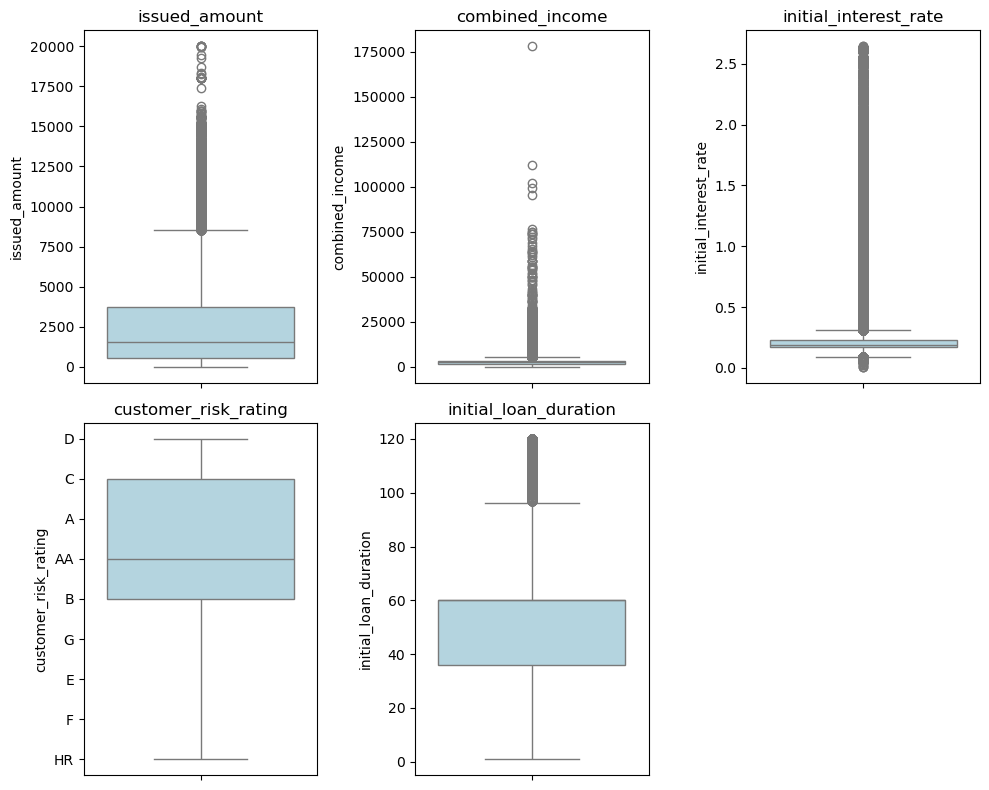

In [8]:
key_cols = ['issued_amount','combined_income','initial_interest_rate','customer_risk_rating','initial_loan_duration']

plt.figure(figsize=(10, 8))
for i, col in enumerate(key_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(col)
    plt.tight_layout()

plt.show()

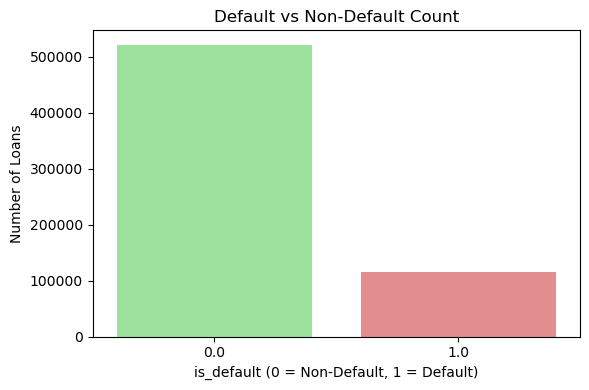

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(
    x='is_default',
    hue='is_default',
    data=df,
    palette=['lightgreen', 'lightcoral'],
    legend=False
)
plt.title("Default vs Non-Default Count")
plt.xlabel("is_default (0 = Non-Default, 1 = Default)")
plt.ylabel("Number of Loans")
plt.tight_layout()
plt.show()

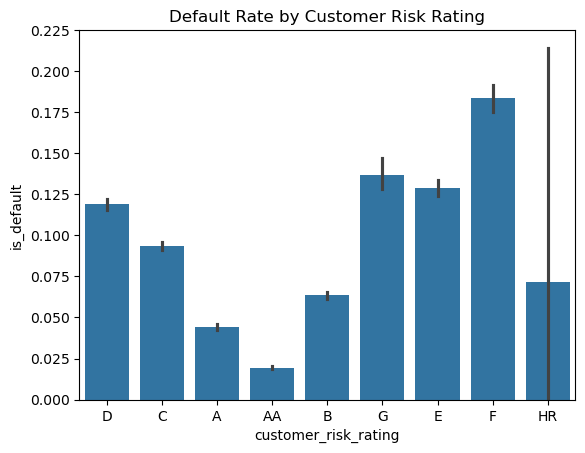

In [10]:
sns.barplot(x='customer_risk_rating', y='is_default', data=df)
plt.title("Default Rate by Customer Risk Rating")
plt.show()

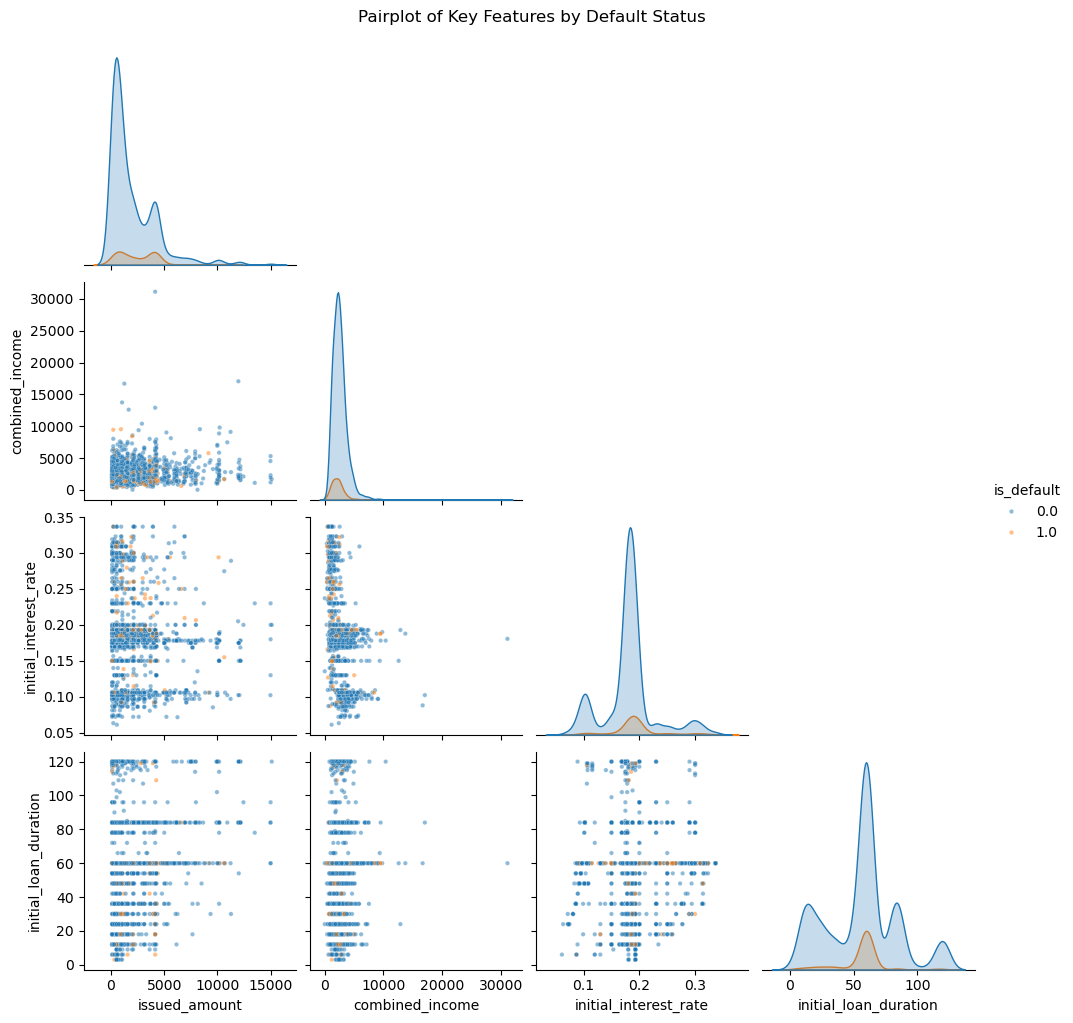

In [11]:
pairplot_cols = [
    'issued_amount',
    'combined_income',
    'initial_interest_rate',
    'initial_loan_duration',
    'is_default'
]
sample_df = df[pairplot_cols].dropna().sample(n=3000, random_state=42)

sns.pairplot(
    sample_df,
    hue='is_default',
    corner=True,
    plot_kws={'alpha': 0.5, 's': 10}
)
plt.suptitle("Pairplot of Key Features by Default Status", y=1.02)
plt.show()

In [8]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

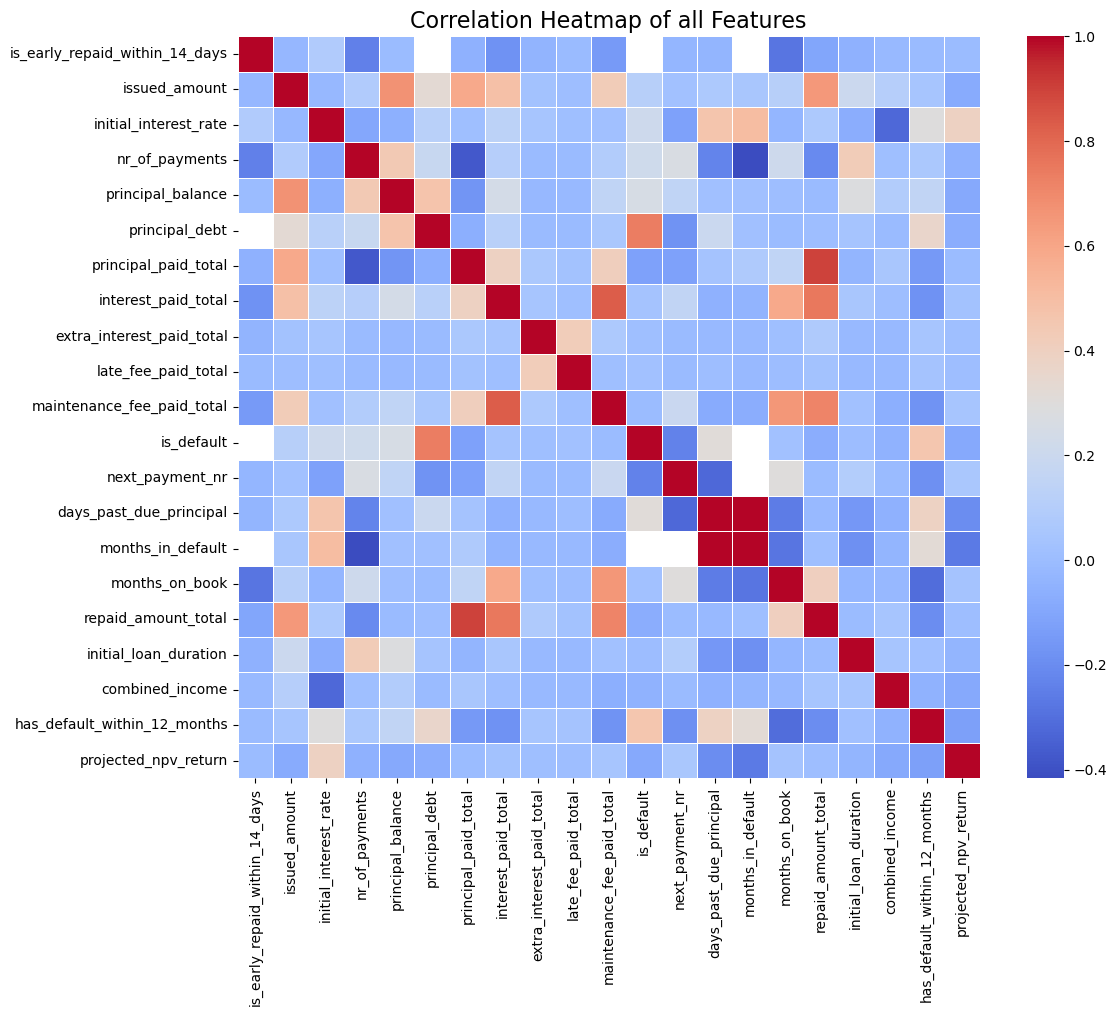

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,cmap='coolwarm',annot=False,linewidths=0.5,square=True)
plt.title("Correlation Heatmap of all Features", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing

In [5]:
missing_percent = df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
cols_to_drop

['early_repaid_at',
 'is_early_repaid_within_14_days',
 'loan_last_recorded_action_date_local',
 'next_payment_date_local',
 'debt_occured_date_local',
 'days_past_due_principal',
 'months_in_default',
 'customer_risk_rating']

In [6]:
for key in ['is_default', 'customer_risk_rating']:
    if key in cols_to_drop:
        cols_to_drop.remove(key)

In [7]:
cols_to_drop

['early_repaid_at',
 'is_early_repaid_within_14_days',
 'loan_last_recorded_action_date_local',
 'next_payment_date_local',
 'debt_occured_date_local',
 'days_past_due_principal',
 'months_in_default']

In [8]:
df1 = df.drop(columns=cols_to_drop, errors='raise')

In [9]:
df1 = df1.drop(columns=['loan_id'], errors='raise')

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644037 entries, 0 to 644036
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   country                       644037 non-null  object        
 1   loan_issued_at                644037 non-null  datetime64[ns]
 2   issued_amount                 644037 non-null  float64       
 3   loan_status                   644037 non-null  object        
 4   initial_interest_rate         644037 non-null  float64       
 5   nr_of_payments                644037 non-null  int64         
 6   principal_balance             636324 non-null  float64       
 7   principal_debt                636324 non-null  float64       
 8   principal_paid_total          636324 non-null  float64       
 9   interest_paid_total           636324 non-null  float64       
 10  extra_interest_paid_total     636324 non-null  float64       
 11  late_fee_paid

In [11]:
df1.isna().sum().sort_values(ascending=False)

customer_risk_rating            338588
combined_income                 273154
projected_npv_return            272283
has_default_within_12_months    168838
months_on_book                    8186
principal_debt                    7713
principal_balance                 7713
next_payment_nr                   7713
is_default                        7713
maintenance_fee_paid_total        7713
late_fee_paid_total               7713
extra_interest_paid_total         7713
repaid_amount_total               7713
interest_paid_total               7713
principal_paid_total              7713
loan_status_risk                     2
initial_interest_rate                0
nr_of_payments                       0
issued_amount                        0
country                              0
loan_issued_at                       0
loan_status                          0
initial_loan_duration                0
dtype: int64

In [12]:
df2 = df1.copy()

In [13]:
leakage_features = ['principal_debt','principal_balance','principal_paid_total','interest_paid_total','extra_interest_paid_total',
    'late_fee_paid_total','maintenance_fee_paid_total','repaid_amount_total','has_default_within_12_months','projected_npv_return',
    'months_on_book','loan_status_risk','next_payment_nr','days_past_due_principal','debt_occured_date_local','next_payment_date_local',
    'loan_last_recorded_action_date_local','loan_status']

In [14]:
df2 = df2.drop(columns=leakage_features, errors='ignore')

In [15]:
print(df2.columns)
df2.isna().sum().sort_values(ascending=False)

Index(['country', 'loan_issued_at', 'issued_amount', 'initial_interest_rate',
       'nr_of_payments', 'is_default', 'initial_loan_duration',
       'combined_income', 'customer_risk_rating'],
      dtype='object')


customer_risk_rating     338588
combined_income          273154
is_default                 7713
country                       0
loan_issued_at                0
nr_of_payments                0
initial_interest_rate         0
issued_amount                 0
initial_loan_duration         0
dtype: int64

In [16]:
df2 = df2.dropna(subset=['is_default'])

In [17]:
df2['is_default'] = df2['is_default'].astype(int)

In [18]:
print(df2['is_default'].value_counts())

is_default
0    520992
1    115332
Name: count, dtype: int64


In [24]:
df2.head()

,country,loan_issued_at,issued_amount,initial_interest_rate,nr_of_payments,is_default,initial_loan_duration,combined_income,customer_risk_rating
0,Finland,2025-09-25 08:56:06.550,200.0,0.1748,78,0,78,1842.36,D
1,Finland,2024-10-20 19:27:50.397,4249.0,0.1877,15,0,60,1045.76,C
2,Finland,2024-11-19 13:33:31.477,207.0,0.1877,49,0,12,2189.57,A
3,Spain,2019-09-28 11:54:11.000,4253.0,0.2620,51,0,36,NaN,NaN
4,Estonia,2020-08-18 11:45:09.000,1063.0,0.3586,60,0,60,NaN,NaN


In [19]:
df2['customer_risk_rating'] = df2['customer_risk_rating'].fillna('Missing')
df2['customer_risk_rating'].value_counts()

customer_risk_rating
Missing    330875
AA          79887
B           61358
C           52065
A           49720
D           31329
E           17605
F            8248
G            5223
HR             14
Name: count, dtype: int64

In [20]:
df2['loan_issued_at'] = pd.to_datetime(df2['loan_issued_at'])

In [21]:
df2['issued_year'] = df2['loan_issued_at'].dt.year
df2['issued_month'] = df2['loan_issued_at'].dt.month

df2 = df2.drop(columns=['loan_issued_at'])

In [23]:
clean_df = df2.copy()

In [24]:
num_cols = ['issued_amount', 'initial_interest_rate', 'nr_of_payments',
            'initial_loan_duration', 'combined_income', 'issued_year', 'issued_month']
clean_df[num_cols] = clean_df[num_cols].fillna(clean_df[num_cols].mean())

In [50]:
order = [['AA', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'HR','Missing']]
encoder = OrdinalEncoder(categories=order)
clean_df['customer_risk_rating'] = encoder.fit_transform(clean_df[['customer_risk_rating']])

0    4.0
1    3.0
2    1.0
3    9.0
4    9.0
Name: customer_risk_rating, dtype: float64

In [52]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [53]:
country_encoded = ohe.fit_transform(clean_df[['country']])
country_encoded_df = pd.DataFrame(country_encoded,columns=ohe.get_feature_names_out(['country']),index=clean_df.index)
clean_df = pd.concat([clean_df.drop(columns=['country']), country_encoded_df], axis=1)

clean_df.head()

,issued_amount,initial_interest_rate,nr_of_payments,is_default,initial_loan_duration,combined_income,customer_risk_rating,issued_year,issued_month,customer_risk_rating_le,country_Estonia,country_Finland,country_Latvia,country_Lithuania,country_Netherlands,country_Slovakia,country_Spain
0,200.0,0.1748,78,0,78,1842.360000,4.0,2025,9,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4249.0,0.1877,15,0,60,1045.760000,3.0,2024,10,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,207.0,0.1877,49,0,12,2189.570000,1.0,2024,11,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4253.0,0.2620,51,0,36,2543.799355,9.0,2019,9,9,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1063.0,0.3586,60,0,60,2543.799355,9.0,2020,8,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
clean_subset = clean_df.iloc[:20000].copy()
clean_subset.to_excel("clean_loan_dataset.xlsx", index=False)

In [22]:
target = 'is_default'
feature_cols = ['country','issued_amount','initial_interest_rate','nr_of_payments','initial_loan_duration','combined_income','customer_risk_rating',
    'issued_year','issued_month']

In [23]:
X = df2[feature_cols]
y = df2[target]

X.head()

,country,issued_amount,initial_interest_rate,nr_of_payments,initial_loan_duration,combined_income,customer_risk_rating,issued_year,issued_month
0,Finland,200.0,0.1748,78,78,1842.36,D,2025,9
1,Finland,4249.0,0.1877,15,60,1045.76,C,2024,10
2,Finland,207.0,0.1877,49,12,2189.57,A,2024,11
3,Spain,4253.0,0.2620,51,36,NaN,Missing,2019,9
4,Estonia,1063.0,0.3586,60,60,NaN,Missing,2020,8


In [24]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [25]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['issued_amount', 'initial_interest_rate', 'nr_of_payments', 'initial_loan_duration', 'combined_income', 'issued_year', 'issued_month']
Categorical: ['country', 'customer_risk_rating']


In [26]:
country_feature = ['country']
risk_feature = ['customer_risk_rating']

In [27]:
country_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
risk_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['AA', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'HR','Missing']]))])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('country', country_transformer, country_feature),
        ('risk', risk_transformer, risk_feature)
    ]
)

# Pipelines

In [29]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [30]:
dt_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

In [31]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1,class_weight='balanced'))
])

In [32]:
gb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# K-Fold Validation (5)

In [77]:
scoring = {'accuracy': 'accuracy','precision': 'precision','recall': 'recall','f1': 'f1','roc_auc': 'roc_auc'}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [78]:
log_reg_scores = cross_validate(log_reg, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Logistic Regression (5-fold CV):")
for metric in scoring.keys():
    mean = log_reg_scores[f'test_{metric}'].mean()
    std = log_reg_scores[f'test_{metric}'].std()
    print(f"  {metric}: {mean:.4f} (+/- {std:.4f})")

Logistic Regression (5-fold CV):
  accuracy: 0.7757 (+/- 0.0008)
  precision: 0.4354 (+/- 0.0011)
  recall: 0.8002 (+/- 0.0039)
  f1: 0.5640 (+/- 0.0015)
  roc_auc: 0.8380 (+/- 0.0018)


In [79]:
dt_scores = cross_validate(dt_clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Decision Tree (5-fold CV):")
for metric in scoring.keys():
    mean = dt_scores[f'test_{metric}'].mean()
    std = dt_scores[f'test_{metric}'].std()
    print(f"  {metric}: {mean:.4f} (+/- {std:.4f})")

Decision Tree (5-fold CV):
  accuracy: 0.8501 (+/- 0.0008)
  precision: 0.5813 (+/- 0.0021)
  recall: 0.6185 (+/- 0.0017)
  f1: 0.5993 (+/- 0.0019)
  roc_auc: 0.7579 (+/- 0.0011)


In [80]:
rf_scores = cross_validate(rf_clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Random Forest (5-fold CV):")
for metric in scoring.keys():
    mean = rf_scores[f'test_{metric}'].mean()
    std = rf_scores[f'test_{metric}'].std()
    print(f"  {metric}: {mean:.4f} (+/- {std:.4f})")

Random Forest (5-fold CV):
  accuracy: 0.8737 (+/- 0.0011)
  precision: 0.6682 (+/- 0.0033)
  recall: 0.6022 (+/- 0.0045)
  f1: 0.6335 (+/- 0.0037)
  roc_auc: 0.9132 (+/- 0.0011)


In [81]:
gb_scores = cross_validate(gb_clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)

print("Gradient Boosting (5-fold CV):")
for metric in scoring.keys():
    mean = gb_scores[f'test_{metric}'].mean()
    std = gb_scores[f'test_{metric}'].std()
    print(f"  {metric}: {mean:.4f} (+/- {std:.4f})")

Gradient Boosting (5-fold CV):
  accuracy: 0.8735 (+/- 0.0016)
  precision: 0.6904 (+/- 0.0043)
  recall: 0.5477 (+/- 0.0075)
  f1: 0.6108 (+/- 0.0061)
  roc_auc: 0.9114 (+/- 0.0013)


# Models

In [33]:
sample_weight = compute_sample_weight(class_weight='balanced', y=y)

In [34]:
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight,test_size=0.2,random_state=42,stratify=y)

Logistic Regression

In [42]:
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['issued_amount',
                                                   'initial_interest_rate',
                                                   'nr_of_payments',
                                                   'initial_loan_duration',
                                                   'combined_income',
                                                   'issued_year',
                                                   'issued_month']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country']),
                                                 ('risk',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['AA',
                                                                                               'A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G',
                                                                                               'HR',
                                                                                               'Missing']]))]),
                                                  ['customer_risk_rating'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [43]:
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

In [44]:
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85    104199
           1       0.44      0.80      0.56     23066

    accuracy                           0.78    127265
   macro avg       0.69      0.78      0.71    127265
weighted avg       0.85      0.78      0.80    127265

Test ROC AUC: 0.8360684585462532


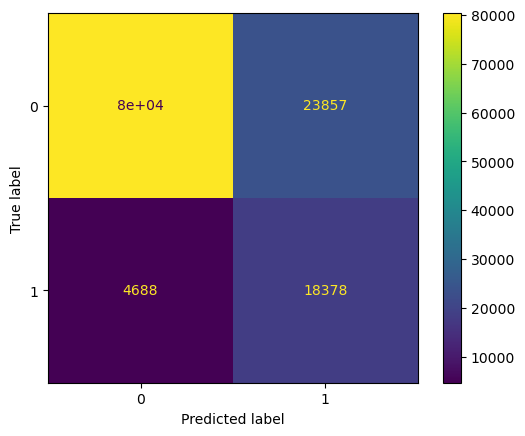

In [45]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [89]:
pre = log_reg.named_steps['preprocessor']
feature_names = pre.get_feature_names_out()

model = log_reg.named_steps['classifier']
coefs = model.coef_[0]

coeff_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs, "AbsCoeff": np.abs(coefs)})

In [90]:
top = coeff_df.sort_values("AbsCoeff", ascending=False).sort_values("Coefficient")
coeff_df = pd.DataFrame({"Feature": feature_names,"Coefficient": coefs,"AbsCoeff": np.abs(coefs)})
colors = ['red' if x > 0 else 'blue' for x in top["Coefficient"]]

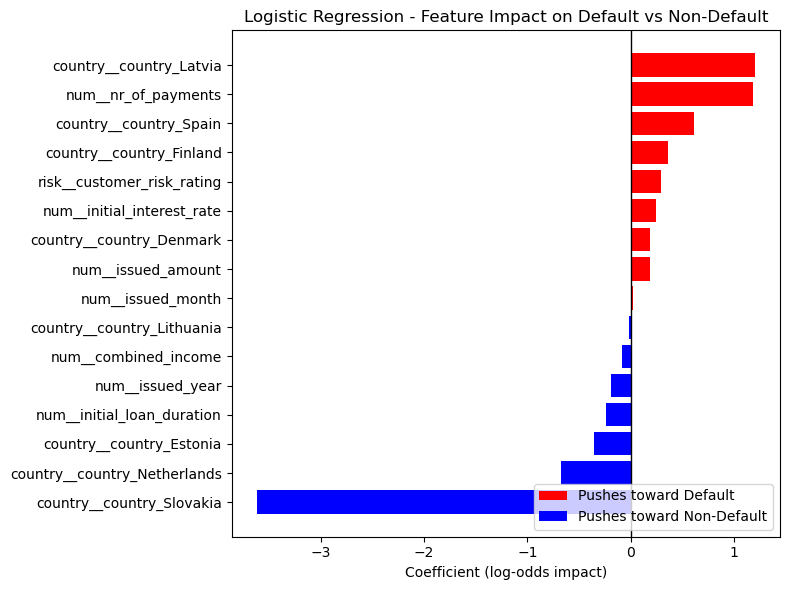

In [91]:
plt.figure(figsize=(8, 6))
bars = plt.barh(top["Feature"], top["Coefficient"], color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient (log-odds impact)")
plt.title("Logistic Regression - Feature Impact on Default vs Non-Default")

legend_elements = [Patch(facecolor='red', label='Pushes toward Default'),
                   Patch(facecolor='blue', label='Pushes toward Non-Default')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

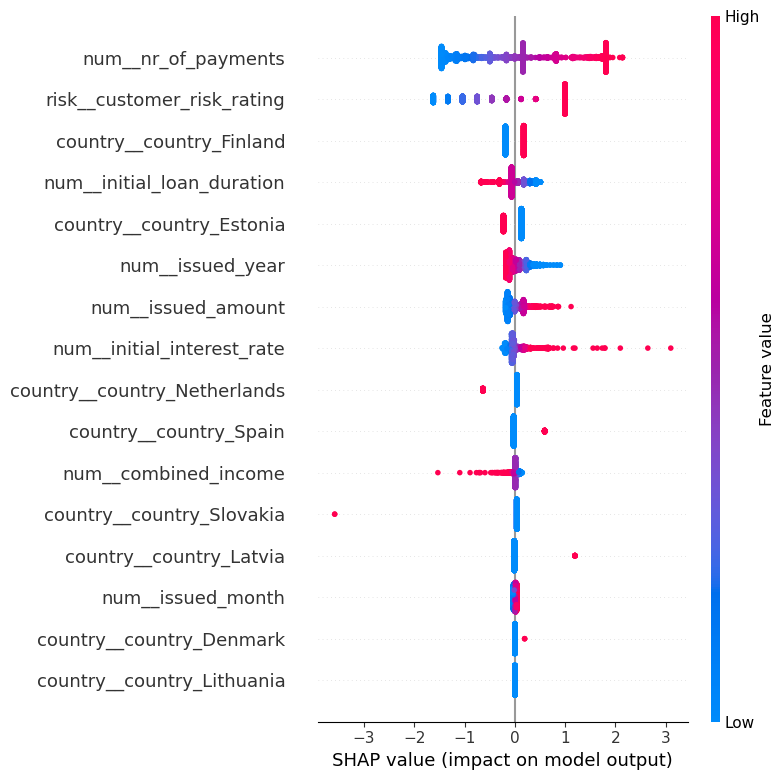

In [92]:
X_sample = shap.sample(X_train, 2000, random_state=42)
X_sample_transformed = pre.transform(X_sample)

explainer = shap.LinearExplainer(model, X_sample_transformed)
shap_values = explainer.shap_values(X_sample_transformed)

shap.summary_plot(shap_values, X_sample_transformed, feature_names=feature_names,class_names=['Non-Default', 'Default'])

Decision Tree

In [35]:
dt_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['issued_amount',
                                                   'initial_interest_rate',
                                                   'nr_of_payments',
                                                   'initial_loan_duration',
                                                   'combined_income',
                                                   'issued_year',
                                                   'issued_month']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country']),
                                                 ('risk',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['AA',
                                                                                               'A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G',
                                                                                               'HR',
                                                                                               'Missing']]))]),
                                                  ['customer_risk_rating'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [36]:
y_pred = dt_clf.predict(X_test)
y_proba = dt_clf.predict_proba(X_test)[:, 1]

In [37]:
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91    104199
           1       0.58      0.62      0.60     23066

    accuracy                           0.85    127265
   macro avg       0.75      0.76      0.75    127265
weighted avg       0.85      0.85      0.85    127265

Test ROC AUC: 0.758546236314406


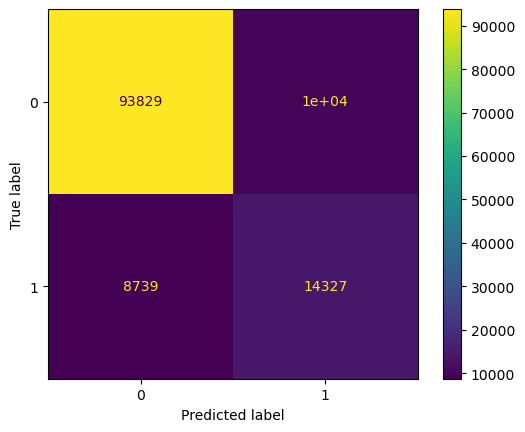

In [48]:
cm_dt = confusion_matrix(y_test, y_pred)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()

In [88]:
pre = dt_clf.named_steps['preprocessor']
feature_names = pre.get_feature_names_out()

dt_model = dt_clf.named_steps['classifier']
importances = dt_model.feature_importances_

In [39]:
dt_df = pd.DataFrame({'feature': feature_names,'importance': importances}).sort_values('importance', ascending=False)

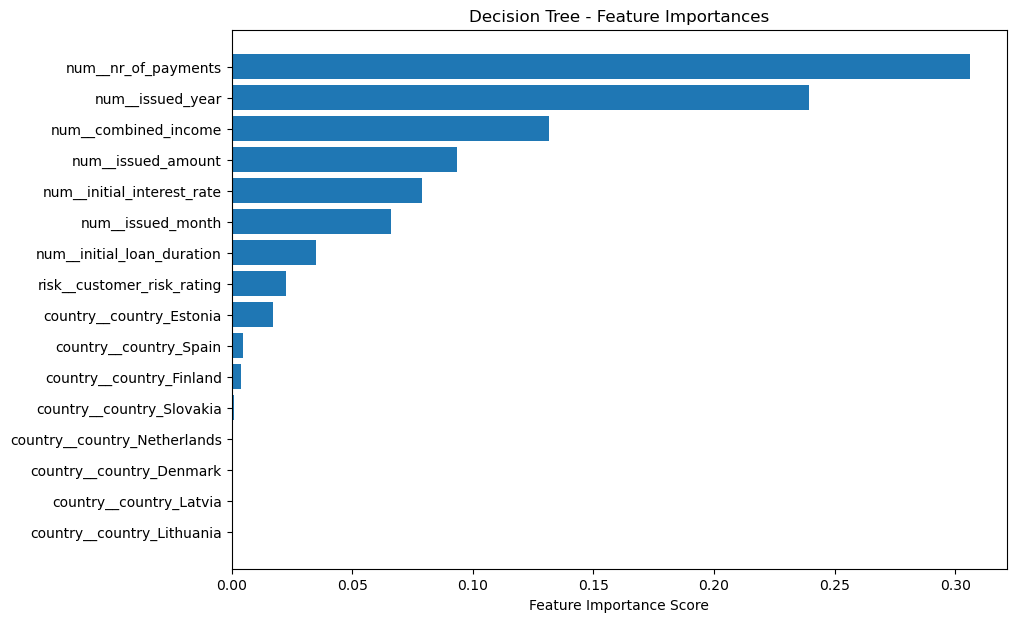

In [40]:
plt.figure(figsize=(10, 7))
plt.barh(dt_df.feature, dt_df.importance)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance Score")
plt.title("Decision Tree - Feature Importances")
plt.show()

Random Forest

In [54]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['issued_amount',
                                                   'initial_interest_rate',
                                                   'nr_of_payments',
                                                   'initial_loan_duration',
                                                   'combined_income',
                                                   'issued_year',
                                                   'issued_month']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequen...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country']),
                                                 ('risk',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['AA',
                                                                                               'A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G',
                                                                                               'HR',
                                                                                               'Missing']]))]),
                                                  ['customer_risk_rating'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [69]:
rf_y_pred = rf_clf.predict(X_test)
rf_y_proba = rf_clf.predict_proba(X_test)[:, 1]

In [70]:
print(classification_report(y_test, rf_y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, rf_y_proba))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92    104199
           1       0.67      0.60      0.63     23066

    accuracy                           0.87    127265
   macro avg       0.79      0.77      0.78    127265
weighted avg       0.87      0.87      0.87    127265

Test ROC AUC: 0.9144796532239545


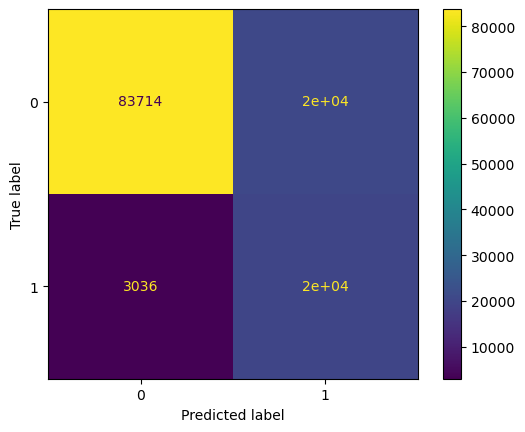

In [71]:
cm_dt = confusion_matrix(y_test, y_pred)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()

In [57]:
pre = rf_clf.named_steps['preprocessor']
feature_names = pre.get_feature_names_out()

rf_model = rf_clf.named_steps['classifier']
importances = rf_model.feature_importances_

In [58]:
rf_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

top = rf_df.sort_values("Importance", ascending=False).head(15).sort_values("Importance")

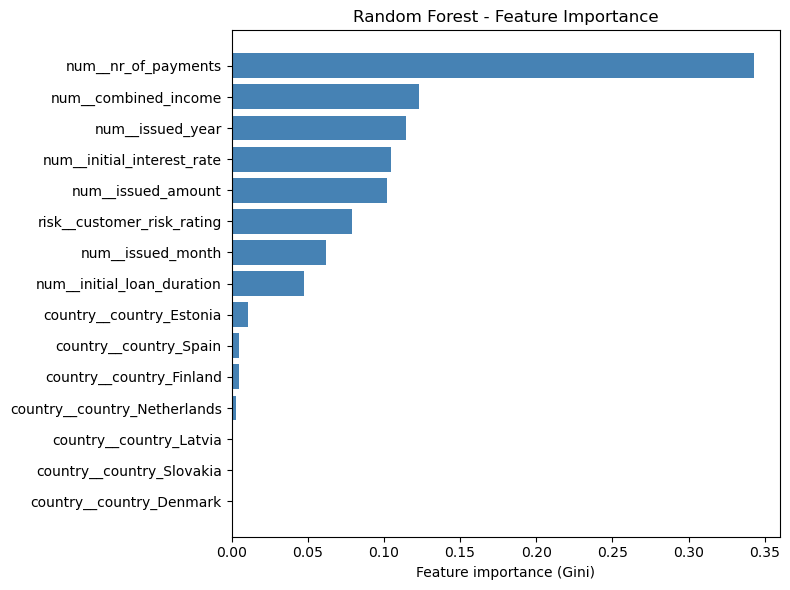

In [59]:
plt.figure(figsize=(8, 6))
plt.barh(top["Feature"], top["Importance"], color="steelblue")
plt.xlabel("Feature importance (Gini)")
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()

Gradient Boosting

In [60]:
gb_clf.fit(X_train, y_train, classifier__sample_weight=sw_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['issued_amount',
                                                   'initial_interest_rate',
                                                   'nr_of_payments',
                                                   'initial_loan_duration',
                                                   'combined_income',
                                                   'issued_year',
                                                   'issued_month']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country']),
                                                 ('risk',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['AA',
                                                                                               'A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G',
                                                                                               'HR',
                                                                                               'Missing']]))]),
                                                  ['customer_risk_rating'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [72]:
y_pred = gb_clf.predict(X_test)
y_proba = gb_clf.predict_proba(X_test)[:, 1]

In [73]:
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88    104199
           1       0.49      0.87      0.63     23066

    accuracy                           0.82    127265
   macro avg       0.73      0.84      0.75    127265
weighted avg       0.88      0.82      0.83    127265

Test ROC AUC: 0.9131386276331578


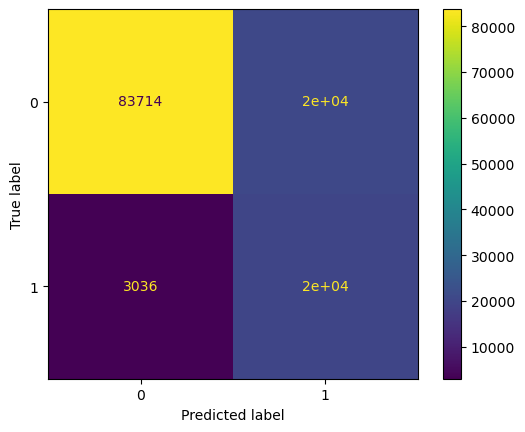

In [74]:
cm_dt = confusion_matrix(y_test, y_pred)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()

In [63]:
pre = gb_clf.named_steps['preprocessor']
feature_names = pre.get_feature_names_out()

gb_model = gb_clf.named_steps['classifier']
importances = gb_model.feature_importances_

In [64]:
gb_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

top = gb_df.sort_values("Importance", ascending=False).tail(15).sort_values("Importance")

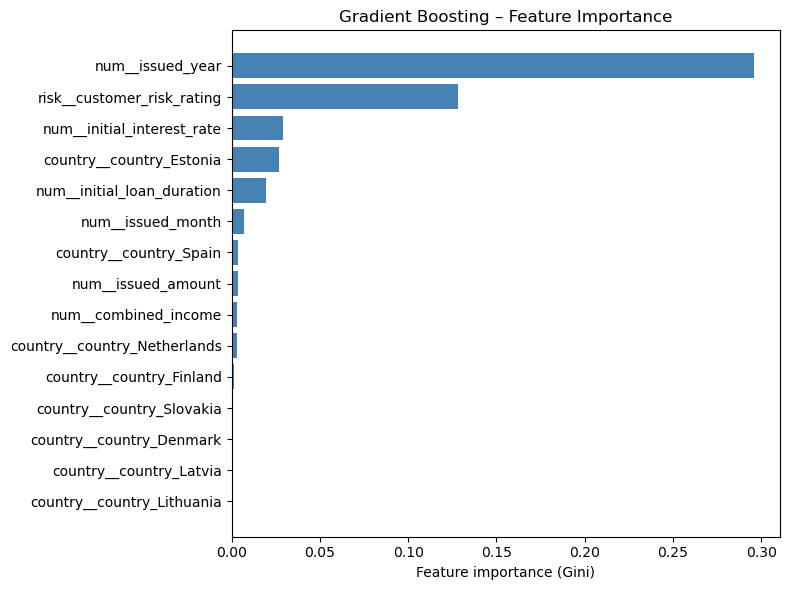

In [65]:
plt.figure(figsize=(8, 6))
plt.barh(top["Feature"], top["Importance"], color="steelblue")
plt.xlabel("Feature importance (Gini)")
plt.title("Gradient Boosting – Feature Importance")
plt.tight_layout()
plt.show()

In [66]:
X_sample = shap.sample(X_train, 2000, random_state=42)
pre = gb_clf.named_steps['preprocessor']
feature_names = pre.get_feature_names_out()
X_sample_transformed = pre.transform(X_sample)

In [67]:
gb_model = gb_clf.named_steps['classifier']
explainer_gb = shap.TreeExplainer(gb_model)
shap_values_gb = explainer_gb.shap_values(X_sample_transformed)

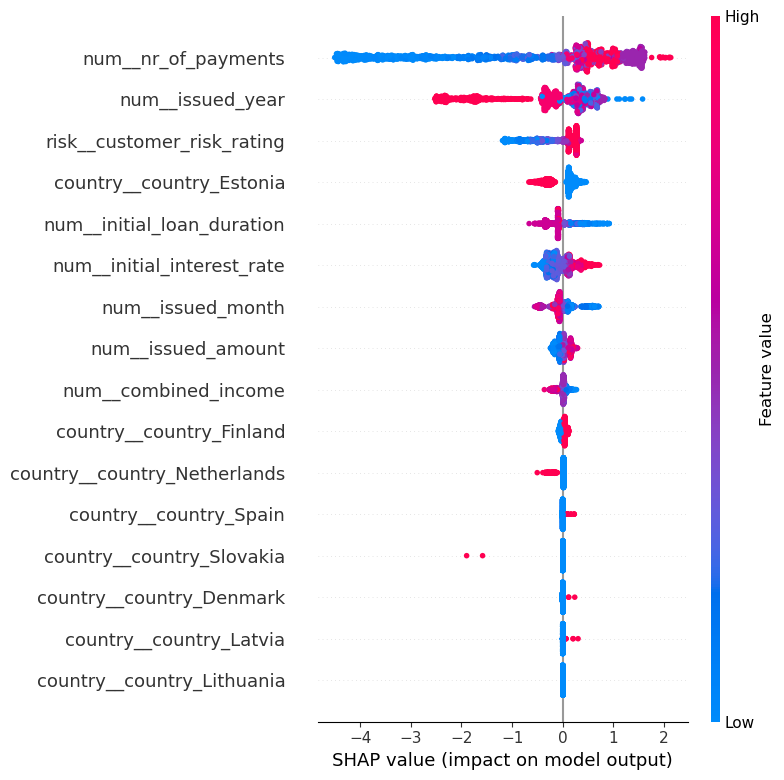

In [68]:
shap.summary_plot(
    shap_values_gb,
    X_sample_transformed,
    feature_names=feature_names,
    class_names=['Non-Default', 'Default']
)